### **CNN CIFAR10 Baseline**

Try to apply all the optimization resources learned and see if you can raise the accuracy. <br>
Now you will apply a convolutional architecture. <br>

Propose a convolutional block architecture that raises the Accuracy. How high can you get? <br>
Multiply the blocks..... <br>
Your best execution will be around 90% <br>
<br>
Using a GPU has a great impact on the execution time. Try to use a GPU <br>

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import os
import tensorflow as tf

# Disable all GPUs
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import tensorflow as tf
from tensorflow.keras import models
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.layers import ReLU, Dense, Softmax, Input, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import L1, L2, L1L2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import ParameterGrid
from scikeras.wrappers import KerasClassifier

import sys
sys.stderr = open('err.txt', 'w')

I0000 00:00:1739815122.870425   10502 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:22:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1739815122.898051   10502 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:22:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1739815122.898095   10502 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:22:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1739815122.900983   10502 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:22:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1739815122.901109   10502 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:22:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

#### **Are we using GPU ?**

In [2]:
# DELETE THIS CELL IF YOU DON'T HAVE A GPU
# Activate GPU
from tensorflow.python.client import device_lib
from tensorflow.config import list_physical_devices
print('Num GPUs Available: ',len(list_physical_devices('GPU')))
devices = device_lib.list_local_devices()
gpu_devices = [device for device in devices if device.device_type == 'GPU']
for gpu in gpu_devices:
    print('Using', gpu.physical_device_desc)

Num GPUs Available:  1
Using device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:22:00.0, compute capability: 8.6


#### **Reading the Dataset**

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [4]:
type(x_train)                # data loaded in numpy arrays
print(x_train.shape, y_train.shape)

(50000, 32, 32, 3) (50000, 1)


In [5]:
label_dict = {0: "airplane",
                     1: "automobile",
                     2: "bird",
                     3: "cat",
                     4: "deer",
                     5: "dog",
                     6: "frog",
                     7: "horse",
                     8: "ship",
                     9: "truck"}

#### **Print some  random images as an example**

<Figure size 3200x3200 with 0 Axes>

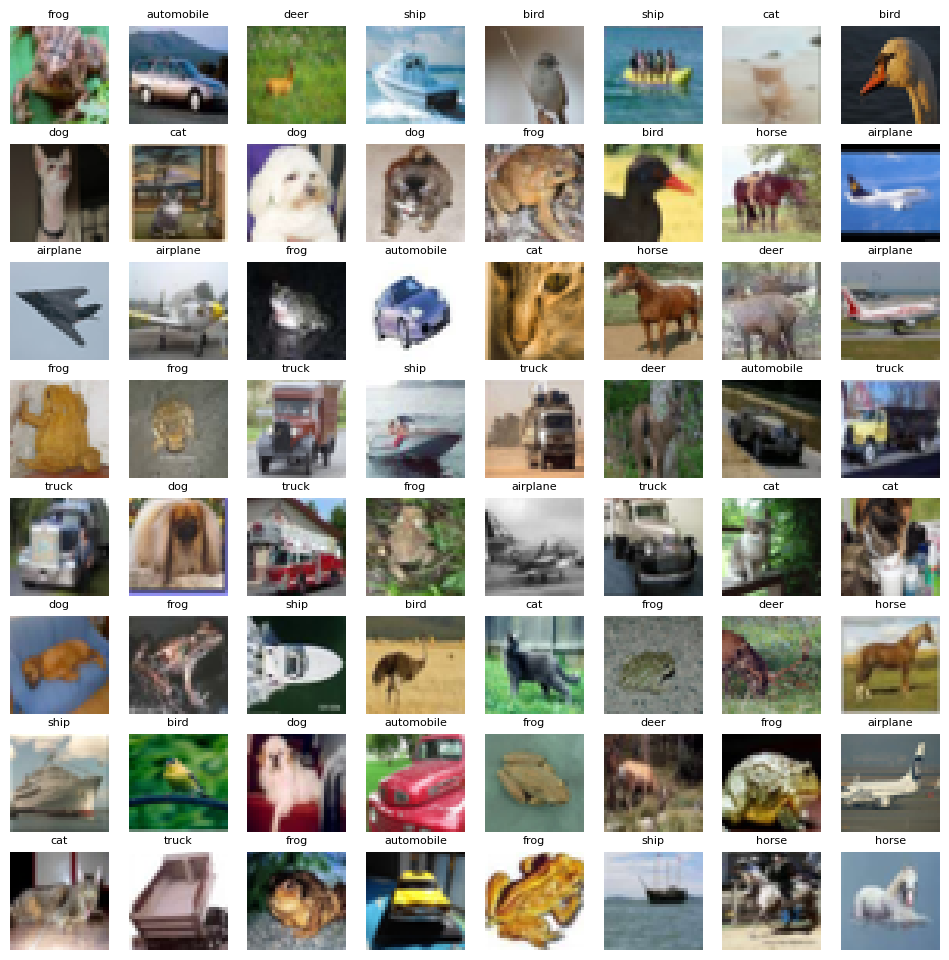

In [6]:
nrows = 4
ncols = 4
total_images = x_train.shape[0]

random_indices = np.random.choice(total_images, 64, replace = False)
random_images = x_train[random_indices]
random_labels = y_train[random_indices].ravel()
descriptive_labels = [label_dict[i] for i in random_labels]

fig = plt.gcf()
fig.set_size_inches(ncols * 8, nrows * 8)

fig, axes = plt.subplots(8,8, figsize=(12,12))

for i, ax in enumerate(axes.flat):  
    ax.imshow(random_images[i])  
    ax.axis('off')  
    ax.set_title(descriptive_labels[i], fontsize=8)

plt.savefig('cifar.png')
plt.show()

#### **Hyperparameters**

In [7]:
learn_rate = 0.0001
num_batch = 64
num_epochs = 150



In [8]:
# reshape images to RGB scale with width & height are size 32
#X_train = x_train.reshape(50000, 32 * 32 * 3)
#X_test = x_test.reshape(10000, 32 * 32 * 3)
X_train = x_train
X_test = x_test

# normalization to avoid gradient explode or vanish
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")
X_train /= 255.0
X_test /= 255.0

# convert class into one hot encoder
y_train = to_categorical(y_train, 10)
y_test  = to_categorical(y_test, 10)
input_shape = X_test.shape[1]
print('Train input shape', X_test.shape, '--- Output shape', y_test.shape)

Train input shape (10000, 32, 32, 3) --- Output shape (10000, 10)


#### **Create ANN**

In [9]:
def build_CNN():
    # Define the input shape
    input_shape = (32, 32, 3)  # CIFAR-10 images are 32x32 RGB images

    # Input layer
    inputs = Input(shape=input_shape)

    # Convolutional BLOCK 1
    x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(x)



    # Flatten and Dense layers
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(10, activation='softmax')(x)  # CIFAR-10 has 10 classes

    # Create the model
    model = Model(inputs=inputs, outputs=outputs)

    # Summary of the model
    model.summary()
    return model


In [10]:
# Configure early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=10,         # Number of epochs with no improvement after which training will be stopped
    verbose=1,           # Log when training is stopped
    mode='min',          # Stop training when the monitored quantity has stopped decreasing
    restore_best_weights = True  # Restore model weights from the epoch with the best value of the monitored quantity
)

adam = Adam(learning_rate=learn_rate)

In [11]:
CNN = build_CNN()
#CNN = VGG16_custom()
CNN.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history = CNN.fit(X_train, y_train, epochs=num_epochs, batch_size=num_batch, validation_data=(X_test, y_test),
                 callbacks=[early_stopping])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 752,842 (2.87 MB)

 Trainable params: 752,394 (2.87 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/150
782/782 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.1574 - loss: 2.2491 - val_accuracy: 0.3378 - val_loss: 1.7743
Epoch 2/150
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3767 - loss: 1.7099 - val_accuracy: 0.4256 - val_loss: 1.6038
Epoch 3/150
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4664 - loss: 1.4987 - val_accuracy: 0.4416 - val_loss: 1.6513
Epoch 4/150
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5228 - loss: 1.3485 - val_accuracy: 0.5856 - val_loss: 1.1761
Epoch 5/150
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5722 - loss: 1.2367 - val_accuracy: 0.6168 - val_loss: 1.0807
Epoch 6/150
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6059 - loss: 1.1533 - val_accuracy: 0.6090 - val_loss: 1.0778
Epoch 7/150
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6296 - loss: 1.0671 - val_accuracy: 0.6695 - val_loss: 0.9417
Epoch 8/150
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6555 - loss: 1.0062 - val_ac

Epoch 51/150
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8991 - loss: 0.3022 - val_accuracy: 0.8434 - val_loss: 0.5285
Epoch 52/150
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9033 - loss: 0.2912 - val_accuracy: 0.8408 - val_loss: 0.5505
Epoch 53/150
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9054 - loss: 0.2904 - val_accuracy: 0.8390 - val_loss: 0.5500
Epoch 54/150
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9055 - loss: 0.2849 - val_accuracy: 0.8474 - val_loss: 0.5155
Epoch 55/150
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9074 - loss: 0.2786 - val_accuracy: 0.8447 - val_loss: 0.5452
Epoch 56/150
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9127 - loss: 0.2728 - val_accuracy: 0.8437 - val_loss: 0.5621
Epoch 57/150
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9109 - loss: 0.2668 - val_accuracy: 0.8418 - val_loss: 0.5690
Epoch 58/150
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9084 - loss: 0.2722 - 

In [12]:
# Evaluate the model
test_loss, test_acc = CNN.evaluate(X_test, y_test, verbose=2)
print(f'Test accuracy: {test_acc * 100:.2f}%')

313/313 - 2s - 7ms/step - accuracy: 0.8474 - loss: 0.5155
Test accuracy: 84.74%


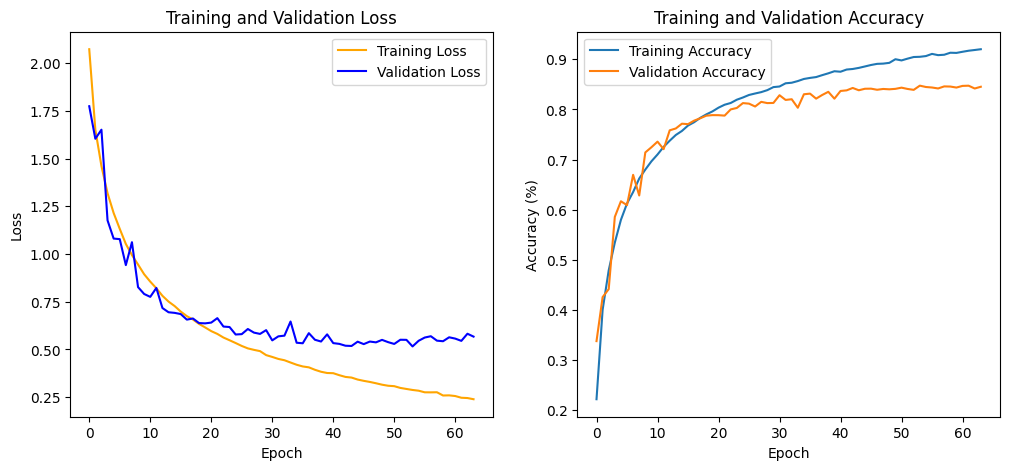

In [13]:
model = CNN
num_classes = 10
# Plot training loss, accuracy and confussion matrix
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='orange')
plt.plot(history.history['val_loss'], label='Validation Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()



313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


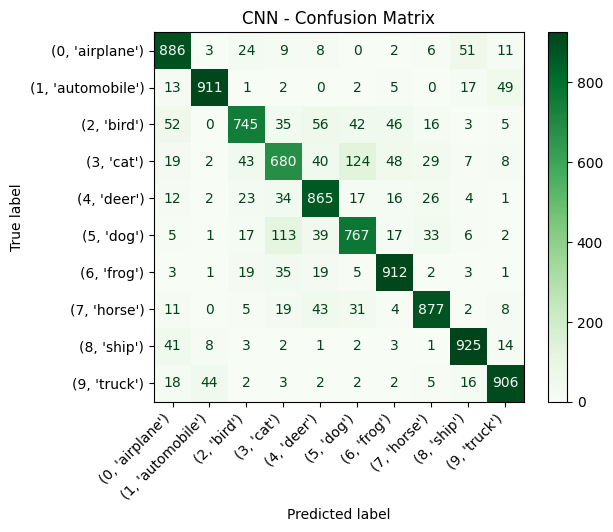

In [14]:
# Confusion Matrix

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true_classes, y_pred_classes)
cmd = ConfusionMatrixDisplay(cm, display_labels=list(label_dict.items()))
cmd.plot(cmap=plt.cm.Greens)
plt.title(f"CNN - Confusion Matrix")
plt.xticks(rotation=45, ha='right')  # ha is the horizontal alignment
plt.show()

##### import session_info
session_info.show(html=False)